# Hvad er det her?
____
### Jeg tænkte det kunne være interessant at kigge lidt på folketingets stemme data.
### Det her dokument går lidt løst frem og undersøger diverse aspekter om data'ene undervejs.
### Det betyder at del-resultaterne ikke bør tages for 100% sandhed da jeg ikke har det fulde billede endnu

# Lidt info at huske på

## 4 stemmetyper:
    * 1: For
    * 2: Imod
    * 3: Fraværende
    * 4: Hverken for eller imod
    
    
## 12 Aktørtyper
    * 4: Parti
    * 5: Person

# Hvad kan vi så spørge om...
* Hvem stemmer mest nej? (person, parti)
* Hvem stemmer mest ja?  (person, parti)
* Hvis vi køre PCA (eller MCA eller CorEx) på personer, kommer de så til at cluster efter parti? Er der nogen der hører til et andet sted?
* Hvis vi gør det samme på parti niveau ser vi så vestre vs højre fløj?
* Hvem er den mest/mindst parti loyale person?
* ...
* Er der et mindre antal afstemninger der hvis samlede resultat kan adskille alle partierne således at de kunne bruges som en test til at se hvem du er mest enige med?

In [173]:
#import ting og sager til grafer og databehandling
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")


In [2]:
#import django til at læse databasen
# DETTE FELT SKAL KUN KØRES 1 GANG. Ellers må du restarte kernel.
import os
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'politik.settings')
import django
django.setup()
from django.db.models import Count, Avg
from poligraf import models

In [84]:
#Der er en del partier der har skiftet navn gennem årerne så her er en dict til at holde styr på det
parti_dual_navn = {
    'Alternativet':'Alternativet',
    'Centrum-demokraterne':'Centrum-demokraterne',
    'Danmarks Retsforbund':'Danmarks Retsforbund',
    'Danmarks kommunistiske parti':'Danmarks kommunistiske parti',
    'Dansk Folkeparti':'Dansk Folkeparti',
    'De frie demokrater':'De frie demokrater',
    'De moderate':'De moderate',
    'De uafhængige':'De uafhængige',
    'Demokratisk Folkeparti':'Demokratisk Folkeparti',
    'Den socialistiske arbejdsgruppe':'Den socialistiske arbejdsgruppe',
    'Det Konservative Folkeparti':'Det Konservative Folkeparti',
    'Det Liberale Højre':'Det Liberale Højre',
    'Det Radikale Venstre':'Radikale Venstre',
    'Enhedslisten':'Enhedslisten',
    'Enhedslisten - De Rød-Grønne':'Enhedslisten',
    'Erhvervspartiet':'Erhvervspartiet',
    'Folkeunionen':'Folkeunionen',
    'Fredspolitisk folkeparti':'Fredspolitisk folkeparti',
    'Fremskridtspartiet':'Fremskridtspartiet',
    'Frihed 2000':'Fremskridtspartiet',
    'Fælles Kurs':'Fælles Kurs',
    'Fællespartiet':'Fællespartiet',
    'Fólkaflokkurin':'Fólkaflokkurin',
    'Inuit Ataqatigiit':'Inuit Ataqatigiit',
    'Javnaðarflokkurin':'Javnaðarflokkurin',
    'Kristeligt Folkeparti':'Kristeligt Folkeparti',
    'Kristeligt folkeparti':'Kristeligt Folkeparti',
    'Kristendemokraterne':'Kristendemokraterne',
    'Liberal Alliance':'Liberal Alliance',
    'Liberalt centrum':'Liberalt centrum',
    'Nunatta Qitornai':'Nunatta Qitornai',
    'Ny Alliance':'Liberal Alliance',
    'Radikale Venstre':'Radikale Venstre',
    'Sambandsflokkurin':'Sambandsflokkurin',
    'Siumut':'Siumut',
    'Slesvigsk parti':'Slesvigsk parti',
    'Socialdemokratiet':'Socialdemokratiet',
    'Socialistisk Folkeparti':'Socialistisk Folkeparti',
    'Tjóðveldi':'Tjóðveldi',
    'Tjóðveldisflokkurin':'Tjóðveldi',
    'Trivselspartiet':'Trivselspartiet',
    'Uden for folketingsgrupperne - Aleqa Hammond ':'Uden for folketingsgrupperne - Aleqa Hammond',
    'Uden for folketingsgrupperne - Anders Møller':'Uden for folketingsgrupperne - Anders Møller',
    'Uden for folketingsgrupperne - Anders Storgaard':'Uden for folketingsgrupperne - Anders Storgaard',
    'Uden for folketingsgrupperne - Anker Tang Sørensen':'Uden for folketingsgrupperne - Anker Tang Sørensen',
    'Uden for folketingsgrupperne - Anne Grete Holmsgaard':'Uden for folketingsgrupperne - Anne Grete Holmsgaard',
    'Uden for folketingsgrupperne - Arne Bjerregaard':'Uden for folketingsgrupperne - Arne Bjerregaard',
    'Uden for folketingsgrupperne - Arne Melchior':'Uden for folketingsgrupperne - Arne Melchior',
    'Uden for folketingsgrupperne - Asger Lindinger':'Uden for folketingsgrupperne - Asger Lindinger',
    'Uden for folketingsgrupperne - Bente Juncker':'Uden for folketingsgrupperne - Bente Juncker',
    'Uden for folketingsgrupperne - Bjørn Elmquist':'Uden for folketingsgrupperne - Bjørn Elmquist',
    'Uden for folketingsgrupperne - Børge Diderichsen':'Uden for folketingsgrupperne - Børge Diderichsen',
    'Uden for folketingsgrupperne - Christian H. Hansen':'Uden for folketingsgrupperne - Christian H. Hansen',
    'Uden for folketingsgrupperne - Erik A. Jensen':'Uden for folketingsgrupperne - Erik A. Jensen',
    'Uden for folketingsgrupperne - Erling Askjær Jørgensen':'Uden for folketingsgrupperne - Erling Askjær Jørgensen',
    'Uden for folketingsgrupperne - Flemming Oppfeldt':'Uden for folketingsgrupperne - Flemming Oppfeldt',
    'Uden for folketingsgrupperne - Frank Dahlgaard':'Uden for folketingsgrupperne - Frank Dahlgaard',
    'Uden for folketingsgrupperne - Gitte Seeberg':'Uden for folketingsgrupperne - Gitte Seeberg',
    'Uden for folketingsgrupperne - Hans Jørgen Iversen':'Uden for folketingsgrupperne - Hans Jørgen Iversen',
    'Uden for folketingsgrupperne - Hans Jørgen Lembourn':'Uden for folketingsgrupperne - Hans Jørgen Lembourn',
    'Uden for folketingsgrupperne - Herluf Rasmussen':'Uden for folketingsgrupperne - Herluf Rasmussen',
    'Uden for folketingsgrupperne - Hugo Holm':'Uden for folketingsgrupperne - Hugo Holm',
    'Uden for folketingsgrupperne - Inge Refshauge':'Uden for folketingsgrupperne - Inge Refshauge',
    'Uden for folketingsgrupperne - Jacob Haugaard ':'Uden for folketingsgrupperne - Jacob Haugaard ',
    'Uden for folketingsgrupperne - Jørgen Junior':'Uden for folketingsgrupperne - Jørgen Junior',
    'Uden for folketingsgrupperne - Jørgen Lenger':'Uden for folketingsgrupperne - Jørgen Lenger',
    'Uden for folketingsgrupperne - Jørgen Poulsen':'Uden for folketingsgrupperne - Jørgen Poulsen',
    'Uden for folketingsgrupperne - Kim Behnke':'Uden for folketingsgrupperne - Kim Behnke',
    'Uden for folketingsgrupperne - Kirsten Jacobsen':'Uden for folketingsgrupperne - Kirsten Jacobsen',
    'Uden for folketingsgrupperne - Leif Mikkelsen':'Uden for folketingsgrupperne - Leif Mikkelsen',
    'Uden for folketingsgrupperne - Louise Frevert':'Uden for folketingsgrupperne - Louise Frevert',
    'Uden for folketingsgrupperne - Mogens Andreasen':'Uden for folketingsgrupperne - Mogens Andreasen',
    'Uden for folketingsgrupperne - Morten Messerschmidt':'Uden for folketingsgrupperne - Morten Messerschmidt',
    'Uden for folketingsgrupperne - Naser Khader':'Uden for folketingsgrupperne - Naser Khader',
    'Uden for folketingsgrupperne - Niels Vestergaard Eriksen':'Uden for folketingsgrupperne - Niels Vestergaard Eriksen',
    'Uden for folketingsgrupperne - Niels Westerby':'Uden for folketingsgrupperne - Niels Westerby',
    'Uden for folketingsgrupperne - Ole Donner':'Uden for folketingsgrupperne - Ole Donner',
    'Uden for folketingsgrupperne - Per Ørum Jørgensen':'Uden for folketingsgrupperne - Per Ørum Jørgensen',
    'Uden for folketingsgrupperne - Peter Brixtofte':'Uden for folketingsgrupperne - Peter Brixtofte',
    'Uden for folketingsgrupperne - Pia Christmas-Møller':'Uden for folketingsgrupperne - Pia Christmas-Møller',
    'Uden for folketingsgrupperne - Simon Emil Ammitzbøll':'Uden for folketingsgrupperne - Simon Emil Ammitzbøll',
    'Uden for folketingsgrupperne - Svend Bay':'Uden for folketingsgrupperne - Svend Bay',
    'Uden for folketingsgrupperne - Thorkild B. Fransgaard':'Uden for folketingsgrupperne - Thorkild B. Fransgaard',
    'Uden for folketingsgrupperne - Thure Barsøe-Carnfeldt':'Uden for folketingsgrupperne - Thure Barsøe-Carnfeldt',
    'Uden for folketingsgrupperne - Uffe Elbæk':'Uden for folketingsgrupperne - Uffe Elbæk',
    'Uden for folketingsgrupperne - Uffe Thorndal':'Uden for folketingsgrupperne - Uffe Thorndal',
    'Uden for folketingsgrupperne - valgt i Grønland':'Uden for folketingsgrupperne - valgt i Grønland',
    'Uden for folketingsgrupperne - valgt på Færøerne':'Uden for folketingsgrupperne - valgt på Færøerne',
    'Venstre, Danmarks Liberale Parti':'Venstre, Danmarks Liberale Parti',
    'Venstresocialisterne':'Venstresocialisterne'
}

In [4]:
#Vi laver data'ene om til en dataframe med afstemning, dato, navn og hvad folk stemte

stemmetyper = {1:'for', 2:'imod', 3:'fraværende', 4:'neutral'}
stemmer = pd.DataFrame([{'afstemning':stemme.afstemningid.pk, 
            'stemt': stemmetyper[stemme.typeid], 
            'navn': stemme.aktørid.navn,
            'navn_id': stemme.aktørid_id,
            'dato':datetime.strptime(stemme.afstemningid.mødeid.dato.split("T")[0], "%Y-%m-%d")} 
           for stemme in models.Stemme.objects.all().prefetch_related('aktørid', 'afstemningid__mødeid')])
stemmer.head()

,afstemning,dato,navn,navn_id,stemt
0,1,2014-09-09,Eigil Andersen,158,for
1,1,2014-09-09,Tom Behnke,71,for
2,1,2014-09-09,Liselott Blixt,50,for
3,1,2014-09-09,Erling Bonnesen,49,for
4,1,2014-09-09,Bent Bøgsted,183,for


In [17]:
#Men ofte vil det også være interessant hvilket parti folk er medlem af
#Da folk kan skifte parti, så kommer det an på hvornår afstemningen var.
#Alt i denne celle laver en oversigt over hvornår hvem var i hvilket parti
parti_assigner = pd.DataFrame([pp for pp in models.Aktør.objects.filter(typeid_id=5, 
                                                       tilaktør__fraaktørid__typeid_id=4).values_list(
            'pk', 'tilaktør__fraaktørid__navn', 'tilaktør__startdato', 'tilaktør__slutdato')] + 
             [pp for pp in models.Aktør.objects.filter(typeid_id=5,
                                                       fraaktør__tilaktørid__typeid_id=4).values_list(
            'pk', 'fraaktør__tilaktørid__navn', 'fraaktør__startdato', 'fraaktør__slutdato')], columns=['id', 'parti', 'fra', 'til'])

def unify_navn(parti):
    return parti_dual_navn[parti]

def make_dato(dato):
    if dato != None:
        return datetime.strptime(dato.split("T")[0], "%Y-%m-%d")
    return np.nan

parti_assigner['parti'] = parti_assigner['parti'].apply(unify_navn)
parti_assigner['fra'] = parti_assigner['fra'].apply(make_dato)
parti_assigner['til'] = parti_assigner['til'].apply(make_dato)
parti_assigner.drop_duplicates(inplace=True)
parti_assigner.head()

def simplify(pa):
    new_data_rows = []
    for id in pa.id.unique():
        pas = pa[pa['id'] == id]['parti'].unique()
        if len(pas) == 1:
            new_data_rows.append({'id':id,'parti':pas[0], 'fra':datetime(1900, 1, 1), 'til':datetime(2100, 1, 1)})
        else:
            new_data_rows += pa[pa['id']==id].to_dict('records')
    return new_data_rows
            
parti_assigner = pd.DataFrame(simplify(parti_assigner))
parti_assigner.head()

,fra,id,parti,til
0,1900-01-01,5,Enhedslisten,2100-01-01
1,1900-01-01,13,Inuit Ataqatigiit,2100-01-01
2,1900-01-01,18,Dansk Folkeparti,2100-01-01
3,1900-01-01,34,Dansk Folkeparti,2100-01-01
4,1900-01-01,39,Enhedslisten,2100-01-01


In [36]:
models.Aktør.objects.filter(navn='Carsten Hansen')

<QuerySet [<Aktør: Aktør object (92)>, <Aktør: Aktør object (5593)>, <Aktør: Aktør object (5734)>]>

In [18]:
#den info kan vi så bruge på at placere folk i deres respektive partier på de givne afstemningstidpunkter

def party_time(row):
    #brug afstemningsdato og person id til at afgøre medlemskab på dato
    a = parti_assigner[(parti_assigner.id == row['navn_id']) & (parti_assigner.fra <= row['dato'])]
    if len(a)==0:
        #print(row)
        if row['navn_id'] == 16074: #Steen Holm Iversen er ikke skrevet korrekt ind...han er LA
            return "Liberal Alliance"
        return "error"
    else:
        return a.sort_values(by='fra', ascending=False).iloc[0]['parti']
stemmer['parti'] = stemmer.apply(party_time, axis=1)

afstemning                   4449
dato          2008-04-08 00:00:00
navn             René Christensen
navn_id                      7737
stemt                         for
Name: 775907, dtype: object
afstemning                   4449
dato          2008-04-08 00:00:00
navn               Carsten Hansen
navn_id                      5593
stemt                     neutral
Name: 775933, dtype: object
afstemning                   4449
dato          2008-04-08 00:00:00
navn                Torben Hansen
navn_id                      7633
stemt                         for
Name: 775937, dtype: object
afstemning                      4449
dato             2008-04-08 00:00:00
navn          Mogens Jensen, Brøndby
navn_id                         5905
stemt                        neutral
Name: 775960, dtype: object
afstemning                   4450
dato          2008-04-08 00:00:00
navn             René Christensen
navn_id                      7737
stemt                         for
Name: 776086, dtype: ob

In [39]:
# problem...de nedenstående antal stemmer kommer tilsyneladende fra alternative Aktør kontoer...mystisk
stemmer[stemmer['parti'] == 'error'].navn.value_counts()

Carsten Hansen              1732
Torben Hansen               1715
Jytte Andersen              1563
Frode Sørensen, Hjørring    1558
Mogens Jensen, Brøndby      1438
René Christensen             153
Rigmor Dam                    12
Name: navn, dtype: int64

In [44]:
print(f"Der er {len(stemmer.afstemning.unique())} afstemninger registreret")

Der er 7084 afstemninger registreret


In [86]:
big_players = ['Alternativet', 'Tjóðveldi', 'Sambandsflokkurin', 'Javnaðarflokkurin', 'Liberal Alliance', 'Siumut', 'Inuit Ataqatigiit', 'Socialistisk Folkeparti', 'Socialdemokratiet', 'Radikale Venstre', 'Enhedslisten', 'Det Konservative Folkeparti', 'Dansk Folkeparti', 'Venstre, Danmarks Liberale Parti']

In [67]:
#nå, så nogle spørgsmål: tillader partierne at deres folk stemmer frit eller er de strikse på partilinjen?

parti_basis = {}

for af in stemmer.afstemning.unique():
    for parti in stemmer[stemmer.afstemning == af]['parti'].unique():
        if parti not in parti_basis:
            parti_basis[parti] = [0,0]
        parti_basis[parti][1] += 1
    b1 = stemmer[(stemmer.afstemning == af) & (stemmer.stemt == 'for')]['parti'].unique()
    b2 = stemmer[(stemmer.afstemning == af) & (stemmer.stemt == 'imod')]['parti'].unique()
    both_sides = set(b1).intersection(b2)
    if len(both_sides) != 0:
        for parti in both_sides:
            parti_basis[parti][0] += 1

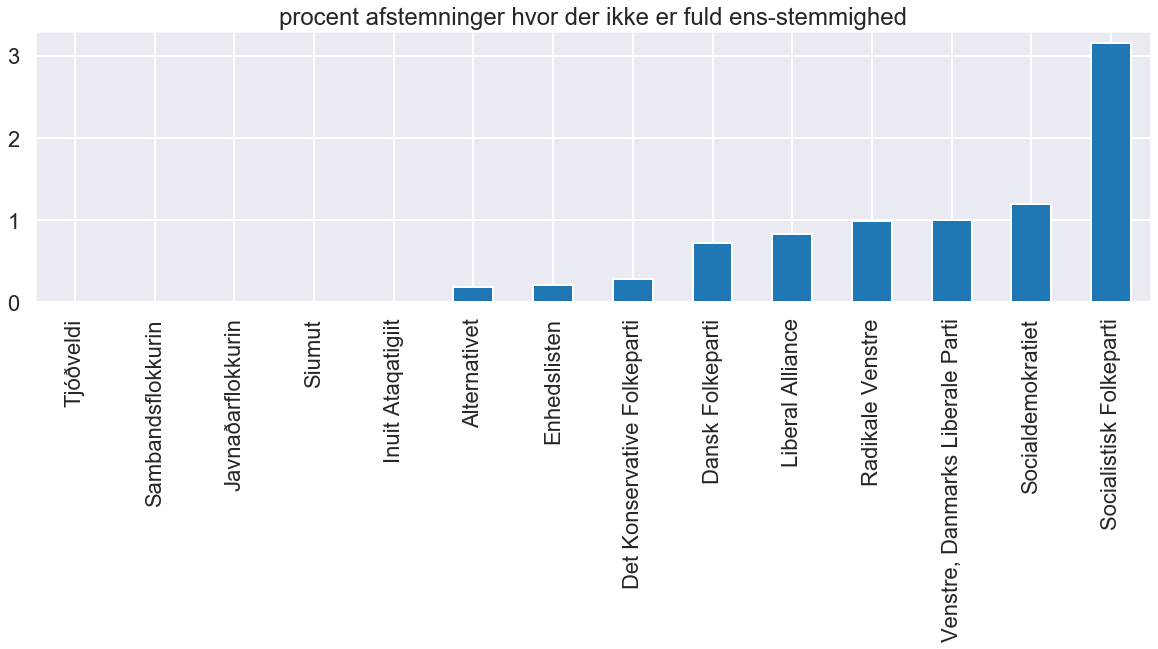

In [148]:
bla = pd.DataFrame(parti_basis).T
((bla[0]/bla[1])*100)[big_players].sort_values().plot(kind='bar', figsize=(20,5), title="procent afstemninger hvor der ikke er fuld ens-stemmighed")

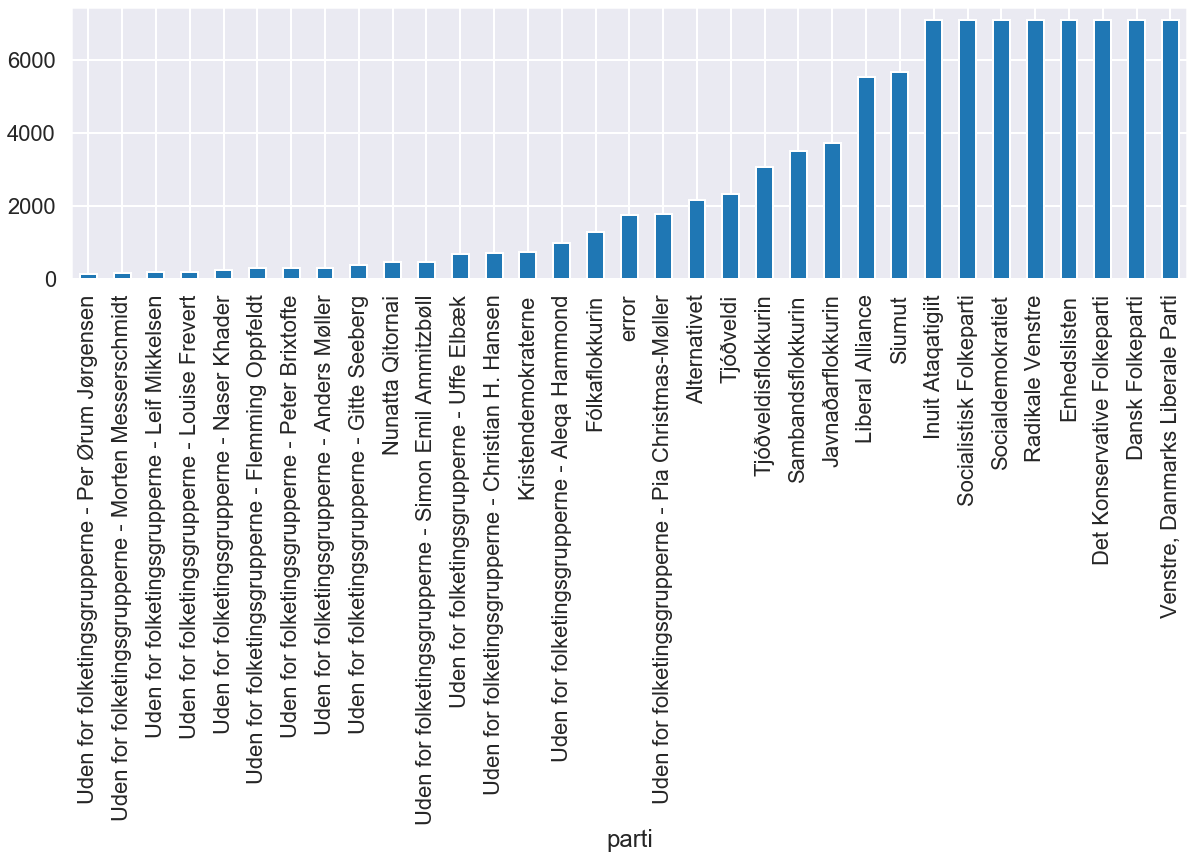

In [149]:
stemmer.pivot_table(columns='parti', index='afstemning', aggfunc=len).count()['stemt'].sort_values().plot(kind='bar', figsize=(20,5))

## Ok så der er af og til nogen der stemmer imod partiet ...er der nogen specifikt der gør det eller er det bare lige en enkelt person fra tid til anden?

In [89]:
person_basis = {}

for af in stemmer.afstemning.unique():
    for person in stemmer[stemmer.afstemning == af]['navn'].unique():
        if person not in person_basis:
            person_basis[person] = [0,0]
        person_basis[person][1] += 1
    b1 = stemmer[(stemmer.afstemning == af) & (stemmer.stemt == 'for')]['parti'].unique()
    b2 = stemmer[(stemmer.afstemning == af) & (stemmer.stemt == 'imod')]['parti'].unique()
    both_sides = set(b1).intersection(b2)
    if len(both_sides) != 0:
        for parti in both_sides:
            whoisit = stemmer[(stemmer.afstemning == af) & (stemmer.parti == parti)]
            if len(whoisit[whoisit.stemt == 'for']) > len(whoisit[whoisit.stemt == 'imod']):
                for person in whoisit[whoisit.stemt == 'imod']['navn']:
                    person_basis[person][0] +=1
            else:
                for person in whoisit[whoisit.stemt == 'for']['navn']:
                    person_basis[person][0] +=1

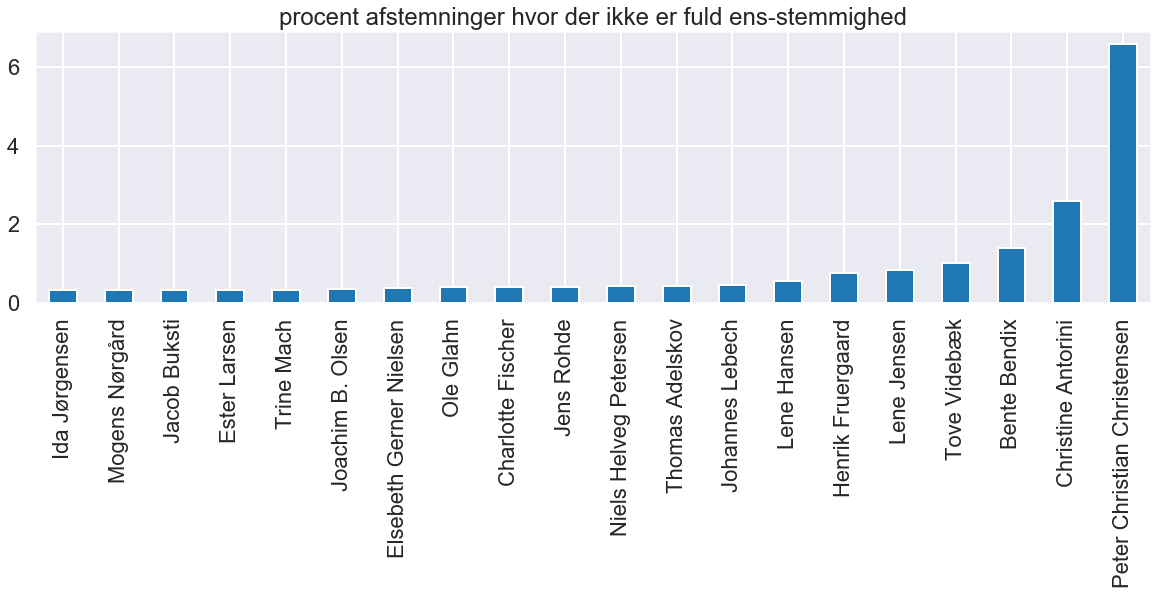

In [150]:
bla = pd.DataFrame(person_basis).T
((bla[0]/bla[1])*100).sort_values()[-20:].plot(kind='bar', figsize=(20,5), title="procent afstemninger hvor der ikke er fuld ens-stemmighed")

## Hm hm...Peter Christian Christensen er lidt af en rebel...men overall en mindre håndfuld få gange....hovedsageligt bliver partilinjen fulgt

Nå..lad os kigge på hvor meget de enkelte personer stemmer

In [100]:
sum_stem = stemmer.pivot(index='afstemning', columns='navn', values='stemt').apply(pd.value_counts).T
sum_stem.head()

,for,fraværende,imod,neutral
navn,,,,
Aage Frandsen (udpeget af SF),213.0,18.0,62.0,1.0
Aaja Chemnitz Larsen,14.0,1725.0,16.0,261.0
Aase D. Madsen (udpeget af DF),24.0,NaN,4.0,266.0
Abbas Razvi,NaN,1.0,NaN,1.0
Aksel V. Johannesen,NaN,NaN,NaN,35.0


In [105]:
#fravær
(sum_stem['fraværende']/sum_stem.T.sum()).dropna().sort_values()

navn
Carina Christensen                   0.000299
Jakob Axel Nielsen                   0.000385
Bendt Bendtsen                       0.000414
Anders Fogh Rasmussen                0.000455
Per Bisgaard                         0.000563
Helle Sjelle                         0.000598
Jens Kirk                            0.000598
Christian Wedell-Neergaard           0.000640
Charlotte Antonsen (udpeget af V)    0.000640
Jørgen Winther                       0.000640
Britta Schall Holberg                0.000656
Jens Rohde                           0.000799
Flemming Møller (udpeget af V)       0.000839
Connie Hedegaard                     0.000864
Henriette Kjær                       0.000901
Helge Adam Møller                    0.000909
Knud Kristensen                      0.000957
Jørgen S. Lundsgaard                 0.001081
Preben Rudiengaard                   0.001197
Thor Pedersen                        0.001197
Irene Simonsen                       0.001201
Flemming Hansen              

### Søren Pape er lidt en pjækkemås. Men det er alle top-politikerne....men grundlæggende ser jeg heller ikke nødvendigheden af at de er fysisk tilstede. Udstyr dem med en app der popper op når der er afstemning.

In [106]:
# så per afstemning skal vi skifte personer ud med parti-linjen
# det bliver en væsentligt mindre dataframe.
# den kan vi så sætte op som en parti x afstemning array med for/imod per afstemning
# det burde kunne kastes ind i noget PCA...=)

In [108]:
parti_stemme = []

for af in stemmer.afstemning.unique():
    b1 = stemmer[(stemmer.afstemning == af) & (stemmer.stemt == 'for')]['parti']
    b2 = stemmer[(stemmer.afstemning == af) & (stemmer.stemt == 'imod')]['parti']
    c1 = set(b1)
    c2 = set(b2)
    both_sides = c1.intersection(c2)
    if len(both_sides) != 0:
        for parti in both_sides:
            if sum(b1==parti)>sum(b2==parti):
                c2.remove(parti)
            else:
                c1.remove(parti)
    parti_stemme.append({**{key:1 for key in c1},**{key:2 for key in c2}})

In [109]:
parti_stemme_df = pd.DataFrame(parti_stemme)
parti_stemme_df = parti_stemme_df.fillna(0)

In [175]:
# lad os kigge på dem der har været der "altid"
full_time = parti_stemme_df[[
 'Liberal Alliance',
 'Socialistisk Folkeparti',
 'Socialdemokratiet',
 'Radikale Venstre',
 'Enhedslisten',
 'Det Konservative Folkeparti',
 'Dansk Folkeparti',
 'Venstre, Danmarks Liberale Parti']]

## ok en matematisk analyse af hvordan stemmerne gruppere sig mellem partierne

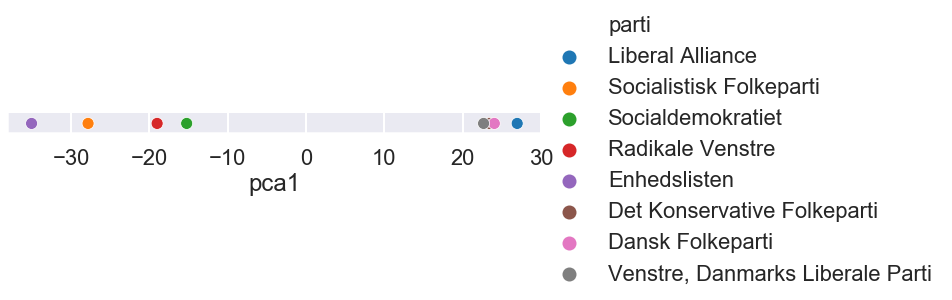

In [176]:
pca = PCA(n_components=1)
pcad = pca.fit_transform(full_time.T)
pca_med_navn = pd.DataFrame(data=pcad, index=full_time.T.index).reset_index()
pca_med_navn.columns = ['parti', 'pca1']
pca_med_navn['statisk'] = [0 for x in range(len(full_time.T.index))]
pca_med_navn['pca1'] *= -1
g = sns.relplot(x='pca1', y='statisk', data=pca_med_navn, hue='parti', height=2, aspect=10/2)
g.set(yticks=[])
g.set(ylabel="")

## Det ligner jo næsten det billede tv-avisen bruger =)
## Dog kan man se at højrefløjen ligner hinanden mere end venstrefløjen gør
## MEN at venstrefløjen er tættere på hinanden end de er på f.eks. venste

# Lad os prøve at gøre det 2 dimensionelt

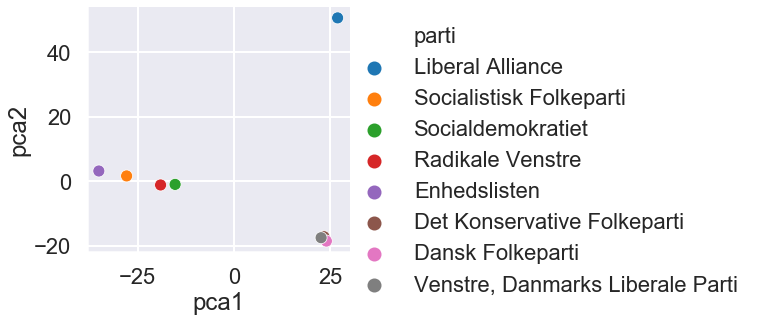

In [178]:
pca = PCA(n_components=2)
pcad = pca.fit_transform(full_time.T)
pca_med_navn = pd.DataFrame(data=pcad, index=full_time.T.index).reset_index()
pca_med_navn.columns = ['parti', 'pca1', 'pca2']
pca_med_navn['pca1'] *= -1
sns.relplot(x='pca1', y='pca2', data=pca_med_navn, hue='parti', aspect=1.3)

# Ca samme billede dog med den forskel at LA ikke helt ligner de andre højre partier...Det skyldes dog nok mest at jeg har sagt de ikke stemte til alle de ting der skete før de kom ind. Hvis jeg kiggede kun på de seneste år ville de nok 100% ligne venstre